In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
plt.rcParams['svg.fonttype'] = 'none'
from upsetplot import UpSet

# Read dummy data

In [2]:
df = pd.read_csv('data/dummy_gene_data.csv')

# Prepare data for upsetplot

In [4]:
samples = ['Sample1', 'Sample2', 'Sample3', 'Sample4', 'Sample5']
threshold = .1

pivot_df = df.pivot_table(index=['gene_id','gene_biotype'], columns='Sample', values='TPM')
bool_df = pivot_df > threshold
count_df = pivot_df.sum(axis=1).rename('TPM')
upset_df = pd.concat([bool_df, count_df], axis=1).reset_index().set_index(samples)

# Define the desired set of intersections
Remaining intersections will be pooled within the 'empty' intersection

In [5]:
intersections_of_interest = [
    (True, True, True, True, True),
    (False, True, True, True, True),
    (True, True, False, False, False),
    (True, False, True, False, False),
    (True, False, False, True, False),
    (True, False, False, False, True),
    (True, False, False, False, False),
    (False, True, False, False, False),
    (False, False, True, False, False),
    (False, False, False, True, False),
    (False, False, False, False, True)
]

# Pooled category index
pooled_index = (False, False, False, False, False)

# Create a new index: keep intersections of interest, map others to pooled_index
new_index = [
    idx if idx in intersections_of_interest else pooled_index
    for idx in upset_df.index
]

# Create the resulting, simplified dataframe:
upset_df_pooled = upset_df.copy()
upset_df_pooled.index = pd.MultiIndex.from_tuples(new_index, names=upset_df.index.names)

# Optionnal: rescale the data within each intersection:
upset_df_pooled['TPM_scaled_per_subset'] = (
    10**6 * upset_df_pooled['TPM'] / upset_df_pooled.groupby(level=upset_df_pooled.index.names)['TPM'].transform(sum)
)

# Draw the upsetplot

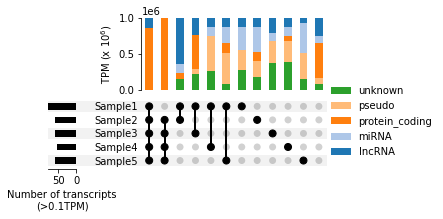

In [7]:
upset = UpSet(
    upset_df_pooled,
    subset_size="auto",
    intersection_plot_elements=0,
    element_size=20,
    sort_categories_by='-input',
    sort_by='-degree'
)

upset.add_stacked_bars(
    by="gene_biotype",
    colors=cm.tab20,
    title="Biotype",
    elements=5,
    sum_over='TPM_scaled_per_subset'
)

axes = upset.plot()

axes['extra0'].set(ylabel='TPM (x $10^6$)')
axes['extra0'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 1e-6}'))
axes['totals'].set(xlabel=f'Number of transcripts\n(>{threshold}TPM)')
axes['extra0'].grid(visible=False)
axes['totals'].grid(visible=False)

plt.legend(loc=(1,-1), frameon=False)

plt.savefig('images/UpSetPlot.png')